# About the Data

This is individual household electric power consumption dataset available at UCI.
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

C:\Users\gyans\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [21]:
df.shape

(2075259, 7)

In [22]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [23]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

# Plot daily data

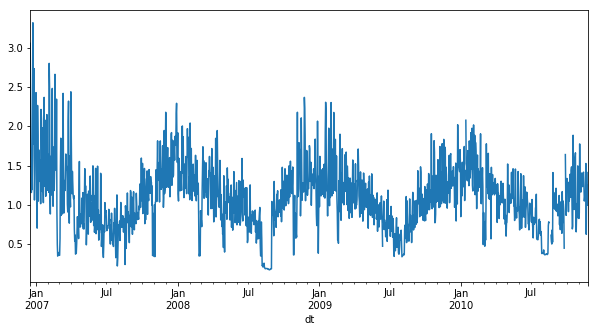

In [51]:
plt.figure(figsize=(10,5))
df.Global_active_power.resample('D').mean().plot()
plt.show()

# Question
When plotted the daily data above - How to know if this has any trend or seasonality ??
If the adfuller test confirms that it is stationary - can we say that it does not have any trend or seasonality ??

# plot Monthly Data

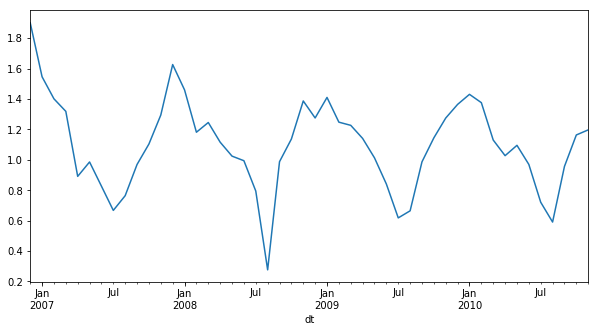

In [50]:
plt.figure(figsize=(10,5))
df.Global_active_power.resample('M').mean().plot()
plt.show()

# Question
from the above plot of monthly data, we can say that it has some seasonality, high global active power during month  of Dec or Jan and Lowest during July or August
Is this correct ?

In [33]:
df_power_day = df.Global_active_power.resample('D').mean().reset_index()

In [34]:
df_power_day.shape

(1442, 2)

In [35]:
type(df_power_day)

pandas.core.frame.DataFrame

In [36]:
df_power_day.head()

,dt,Global_active_power
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [38]:
df_power_day.isnull().sum()

dt                     0
Global_active_power    9
dtype: int64

In [39]:
df_power_day = df_power_day.dropna()

In [42]:
df_power_day = df_power_day.set_index('dt')

In [43]:

def test_stationarity(timeseries):
     
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # dftest[0] is test statistics value, 1 is p-value etc..
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [44]:
test_stationarity(df_power_day.Global_active_power)

Results of Dickey-Fuller Test:
Test Statistic                   -3.684228
p-value                           0.004341
#Lags Used                       22.000000
Number of Observations Used    1410.000000
Critical Value (1%)              -3.434996
Critical Value (5%)              -2.863592
Critical Value (10%)             -2.567862
dtype: float64


In [55]:
df_power_month = df.Global_active_power.resample('M').mean().reset_index()

In [56]:
df_power_month.shape

(48, 2)

In [57]:
df_power_month.isnull().sum()

dt                     0
Global_active_power    0
dtype: int64

In [59]:
df_power_month = df_power_month.set_index('dt')

In [60]:
test_stationarity(df_power_month.Global_active_power)

Results of Dickey-Fuller Test:
Test Statistic                 -4.897270
p-value                         0.000035
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


# Question
But the Monthly data is stationary as per adfuller test. What about the seasonality we saw previously in monthly data?


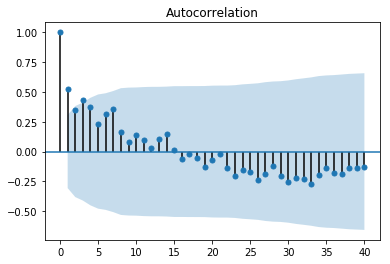

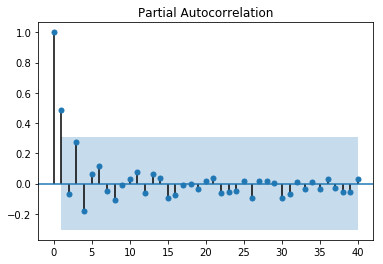

In [61]:
x_acf = pd.DataFrame(acf(df_power_day.Global_active_power))
x_pacf = pd.DataFrame(pacf(df_power_day.Global_active_power))
plot_acf(x_acf)
plot_pacf(x_pacf)
plt.show()

Text(0.5,1,'RSS: 140.5066')

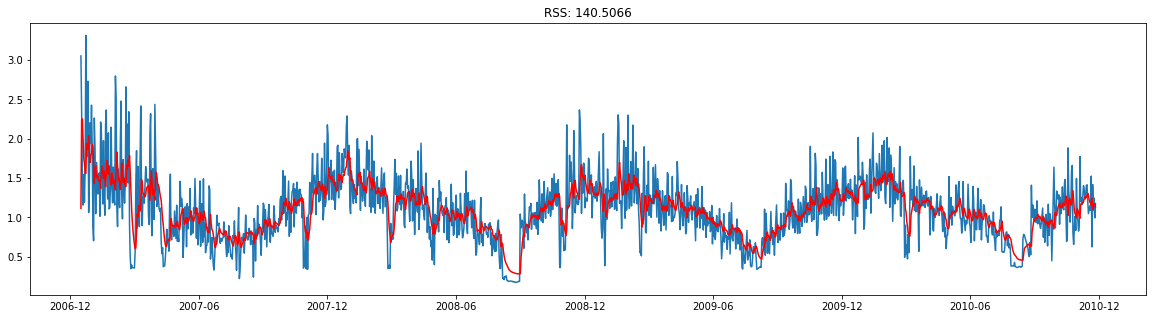

In [65]:
plt.figure(figsize=(20,5))
model = ARIMA(df_power_day.Global_active_power, order=(1,0,1))  
results_MA = model.fit()  
plt.plot(df_power_day.Global_active_power)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_power_day.Global_active_power)**2))

# Question

In this model - the daily data was stationary. So just tried AR and MA of 1.

IS this correct ?